In [1]:
## Inspiration : https://www.kaggle.com/code/teyang/pneumonia-detection-resnets-pytorch

In [2]:
## upload to github!

## 1) Transformations - keep Normalisation for last
## 2) layer freezing
## 3) Optimizer, Criterion 
## 4) Weighted Loss, check different Loss
## 5) Learning Rate
## 6) Gradient Clip
## 7) 3 Models - Res18, Res50, Vgg19

In [3]:
#### Use Directories:
# layer freezing
# Optimizer
# Criterion(Weighted Loss)

In [4]:
## Transformations
## Learning Rate
## Gradient Clip
## 3 Models - Res18, Res50, Vgg19

In [5]:
import os
import numpy as np
import pandas as pd
from os import listdir, makedirs
from os.path import join, exists, expanduser

import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.nn.functional as F
import torch
from torch.utils.data import random_split, DataLoader
import torchvision.models as models
# torchvision.models.resnet18
from torchvision import transforms, datasets

In [6]:
# weights
# epochs
# lr
# optimizer
# modelFn
# gradient_clip
# transformation
# layer freezing
modelDict = {1:"Resnet18",
             2:"Resnet50",
             3:"Vgg19" ## Vgg always runs out of memory
            }

config={"epochs":24,
        "lr":0.001,
        "optimizer":torch.optim.SGD,
        "modelFn":modelDict[2],
        "--transformations":"",
        "weights":False,
        "gradientClip":False,
        "layerFreeze":False
       }

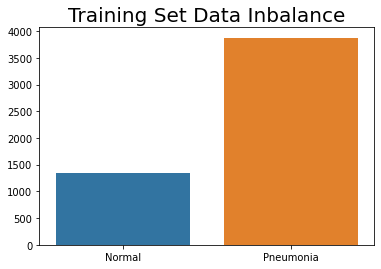

In [7]:
import seaborn as sns
data_dir = '../input/chest-xray-pneumonia/chest_xray/chest_xray'
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(data_dir+'/train/NORMAL', filename) 
                     for filename in os.listdir(data_dir+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(data_dir+'/train/PNEUMONIA', filename) 
                        for filename in os.listdir(data_dir+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Training Set Data Inbalance', fontsize=20)
plt.show()

In [8]:
train_samplesize

,Normal,Pneumonia
0,1342,3876


In [9]:
## Path To Data

In [10]:
ll ../input/chest-xray-pneumonia/chest_xray

total 0
drwxr-xr-x 3 nobody 0 Nov 18  2020 __MACOSX/
drwxr-xr-x 5 nobody 0 Nov 18  2020 chest_xray/
drwxr-xr-x 4 nobody 0 Nov 18  2020 test/
drwxr-xr-x 4 nobody 0 Nov 18  2020 train/
drwxr-xr-x 4 nobody 0 Nov 18  2020 val/


In [11]:
train_data = '../input/chest-xray-pneumonia/chest_xray/chest_xray/train'
test_data = '../input/chest-xray-pneumonia/chest_xray/chest_xray/test'
val_data = '../input/chest-xray-pneumonia/chest_xray/chest_xray/val'

shape:  (1858, 2090)


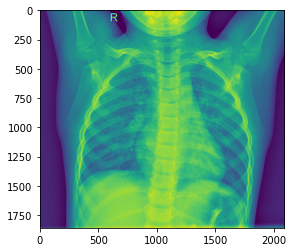

In [12]:
img_path1 = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0115-0001.jpeg"
img1 = plt.imread(img_path1)
plt.imshow(img1)
print("shape: ", img1.shape)

In [13]:
## Find Mean and Std of Data  ../input/chest-xray-pneumonia/

In [14]:
# mean = 0.
# std = 0.
mean = [0., 0., 0.]
std = [0., 0., 0.]
nb_samples = 0.

def sumOnIndex(data, values):
    for i in range(len(data)):
        data[i]+=values[i]
    return data
    
def normalise(loader):
    mean = [0., 0., 0.]
    std = [0., 0., 0.]
    nb_samples = 0.
    for batch_i, data in enumerate(loader):
        data , _ = data
        batch_samples = data.size(0)
        channels = data.size(1)
        data = data.view(batch_samples, channels, -1)
        data_mean=data.mean(2).sum(0)
        mean = sumOnIndex(mean, data_mean)
        data_std=data.std(2).sum(0)
        std = sumOnIndex(std, data_std)
        nb_samples += batch_samples
    
    for i in range(3):
        mean[i] /= nb_samples
        std[i] /= nb_samples
        
    print("mean : ", mean)
    print("std : ", std)
    _mean = mean
    _std = std
    return _mean, _std

# transforms = transforms.Compose([
#     transforms.Resize(size=(256, 256)),
#     transforms.ToTensor()
# ])
# dataset = datasets.ImageFolder(root = train_data, transform=transforms)
# trainLoader = DataLoader(dataset=dataset, batch_size=trainBatchSize, shuffle=True)
# normalise(trainLoader)

In [15]:
## Image Transforms : Normalisation does not give good results on this dataset.
_mean = torch.tensor([0.2807, 0.2807, 0.2807])
_std = torch.tensor([0.2553, 0.2553, 0.2553])

train_transform = transforms.Compose([
    transforms.CenterCrop(1500),
    transforms.Resize(size=(256, 256)),
    transforms.RandomRotation((-30, 30)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.ToTensor(),
#     transforms.Normalize(mean = _mean,
#                          std = _std)
])

val_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.ToTensor()
])

In [16]:
## Create Dataset

In [17]:
trainset = datasets.ImageFolder(root = train_data, transform = train_transform)
print(len(trainset))
valset = datasets.ImageFolder(root = val_data, transform = val_transform)
print(len(valset))
testset = datasets.ImageFolder(root = test_data, transform = test_transform)
print(len(testset))

5216
16
624


In [18]:
## Create Data Loader

In [19]:
# trainBatchSize = 32
trainBatchSize = 128
train_loader = DataLoader(dataset=trainset, batch_size=trainBatchSize, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=9, shuffle=False)
test_loader = DataLoader(dataset=testset, batch_size=9, shuffle=True)

2
0
<class 'torch.Tensor'>
torch.Size([3, 256, 256])
torch.Size([256, 256, 3])


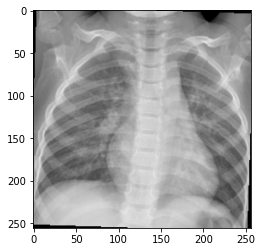

In [20]:
print(len(trainset[0]))
print(trainset[0][1])
img, label = trainset[0]
print(type(img))
print(img.shape)
print(img.permute(1, 2, 0).shape)
plt.imshow(img.permute(1, 2, 0))

torch.Size([3, 256, 256])

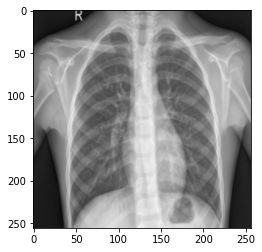

In [21]:
plt.imshow(testset[0][0].permute(1, 2, 0))
testset[0][0].shape

In [22]:
# display 9 imgs
def display_image(imgs, labels, true_labels):
    label_dict = {"0":"Normal", "1":"Pneumonia"}
    fig, ax = plt.subplots(3, 3, figsize=(10, 10))
    axes = ax.flatten()
    for i in range(9):
        imgs_=imgs[i]
        axes[i].set_title(label_dict[str(labels[i].item())]+", "+label_dict[str(true_labels[i].item())])
        imgs_ = imgs_[:]
#         print(imgs_.shape)
        axes[i].imshow(np.reshape(imgs_, (256, 256, 3)))

torch.Size([9, 3, 256, 256])


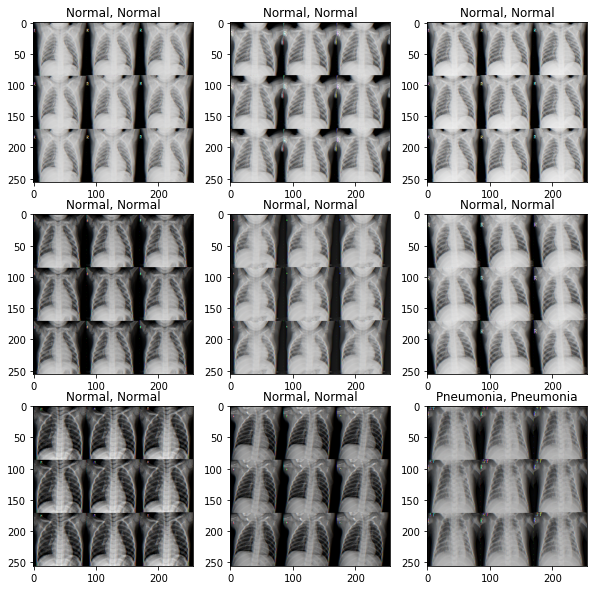

In [23]:
## Check torch.max(outputs, 1)[1]
val_data = next(iter(val_loader))
val_imgs, val_labels = val_data
print(val_imgs.shape)
display_image(val_imgs, val_labels, val_labels)

In [24]:
def to_gpu(resource):
    try:
        if torch.cuda.is_available():
            return resource.to(torch.device('cuda:0'))
        else:
            return resource
    except:
        return resource

In [25]:
## without softmax : nn.CrossEntropyLoss uses softmax in their side, we don't need it in our network
def prepResnet18(num_classes=2, pretrained=True):
    resnet18 = models.resnet18(pretrained=pretrained, progress = True)
    resnet18.fc = torch.nn.Linear(resnet18.fc.in_features, num_classes)
    return resnet18

def prepResnet50(num_classes=2, pretrained=True, imageNet=False):
    resnet50 = models.resnet50(pretrained=pretrained, progress = True)
    resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, num_classes)
    return resnet50

def prepVgg19(bn=True):
    num_classes = 2
    if not bn:
        vgg19 = models.vgg19(pretrained=True, progress = True)
    else:
        vgg19 = models.vgg19_bn(pretrained=True, progress = True)
        vgg19.classifier.add_module("7", torch.nn.Dropout(p=0.4))
        vgg19.classifier.add_module("8", torch.nn.Linear(1000, num_classes))
    return vgg19

In [26]:
# modelDict = {1:"Resnet18",
#              2:"Resnet50",
#              3:"Vgg19"

modelFn = config["modelFn"]
if modelFn == "Resnet18":
    model=prepResnet18()
elif modelFn == "Resnet50":
    model=prepResnet50()
elif modelFn == "Vgg19":
    model=prepVgg19()
model=to_gpu(model)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [27]:
def accuracy(loader, batch_size, model):
    correct = 0
    len_output = 0
    model.eval()
    for batch_i, data in enumerate(loader):
        images, labels = data
        images, labels = to_gpu(images), to_gpu(labels)
        outputs = model(images)
        correct += (torch.max(outputs, 1)[1]==labels).sum()
        if batch_i==0:
            images=images.cpu().numpy()
            display_image(images, torch.max(outputs, 1)[1], labels)
        
        len_output+=len(outputs)
        
    total = len(loader)* batch_size
    print("correct :", correct)
    print("total :", total)
    return (correct/len_output)*100

correct : tensor(8, device='cuda:0')
total : 18


tensor(50., device='cuda:0')

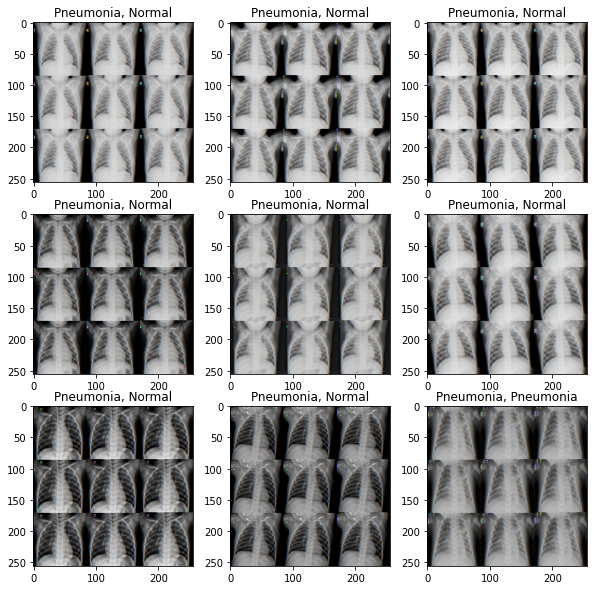

In [28]:
accuracy(val_loader, 9, model)

correct : tensor(387, device='cuda:0')
total : 630


tensor(62.0192, device='cuda:0')

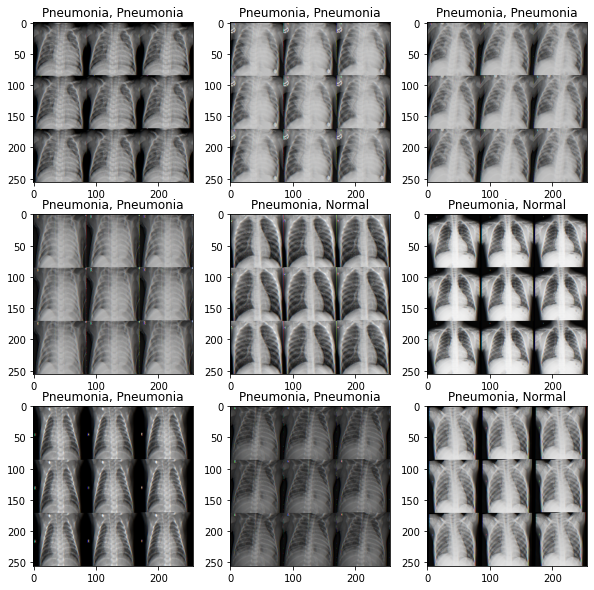

In [29]:
accuracy(test_loader, 9, model)

In [30]:
def checkChildren(layer):
    if hasattr(layer, "children"):
        return list(layer.children())
    else:
        return False

def checkWeight(layer):
    if hasattr(layer, "weight"):
        return True
    else:
        return False

def getWeight(layer):
    if checkWeight(layer):
        print(layer, " : ", layer.weight.requires_grad)
    children=checkChildren(layer)
    for child in children:
        getWeight(child)
# getWeight(model)

# def checkAttr(layer, attr):
#     if hasattr(layer, attr):
#         return True
#     else:
#         return False

# def getWeight_(layer):
#     children=[]
#     if checkAttr(layer, "weight"):  ## checkAttr(layer, "weight")
#         print(layer, " : ", layer.weight.requires_grad)
#     if checkAttr(layer, "children"):  ## checkAttr(layer, "children")
#         children=list(layer.children())
#     for child in children:
#         getWeight_(child)
# getWeight_(model)

In [31]:
def initializeModel(model, modelFn, layers=None, lr=0.001, optimizer=torch.optim.SGD,
                    weight=None, freeze_all=False, gradientClip=False):
    """`freeze all` has priority over `layers`. layers only works for Resnet18"""
    if layers == []:
        layers = None
    smallestChild = np.inf
    largestChild = 0
    params=[]
    params=list(model.parameters())
    for param in params:
        param.requires_grad_(not freeze_all)
    if not freeze_all:
        params = list(model.parameters())
    if freeze_all:
        params = list(model.fc.parameters())
        for param in params:
            param.requires_grad_(freeze_all)
    elif layers:
        if modelFn == "Resnet18":
            for layer in layers:
                getattr(model, "layer"+str(layer)).requires_grad_(False)
                if layer < smallestChild:
                    smallestChild = layer
                if layer > largestChild:
                    largestChild = layer
            firstChildren = list(model.children())[:smallestChild+3] # Resnet has 0-3 layers before the blocks
            secondChildren = list(model.children())[4+largestChild:] # 3+1 = 4

        params=[]
        for ele in firstChildren:
            params += ele.parameters()
        for ele in secondChildren:
            params += ele.parameters()
    getWeight(model)
    if gradientClip:
        clip_value = .98
        for param in params:
            param.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))
    print(len(params))
    criterion = torch.nn.CrossEntropyLoss(weight=weight)
    optimizer = torch.optim.SGD(params,lr = 0.001)
    return criterion, optimizer

# def initializeResnet50():
#     pass

# def initializeVgg19():
#     pass

In [32]:
def initializeModel_(model, freeze_all=False):
    for param in model.parameters():
        param.requires_grad_(not freeze_all)
#     model.fc.requires_grad_(True)
    criterion = torch.nn.CrossEntropyLoss()
    if freeze_all:
        params = model.fc.parameters()
    else:
        params = model.parameters()
    optimizer = torch.optim.Adam(params, lr = 0.001)
    return criterion, optimizer

In [33]:
if config["weights"]:
    weight = to_gpu(torch.FloatTensor([3875/(1341+3875), 1341/(1341+3875)]))
else:
    weight = None

modelFn = config["modelFn"]
criterion, optimizer = initializeModel(model, modelFn, config["layerFreeze"], 
                                       config["lr"], config["optimizer"], weight, config["gradientClip"])

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)  :  True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  True
Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)  :  True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  True
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)  :  True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  True
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)  :  True
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  True
Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)  :  True
BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  True
Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)  :  True
BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)  :  True
Conv

In [34]:
### Train

In [35]:
def train(n_epochs, resnet18, loader, criterion, optimizer, weight=None):

    loss_avg = []
    loss_=[]
    loss_list=[]
    acc_list = []
    resnet18.train()
    r_loss=0
    minAvgLoss = np.inf
    minLoss = np.inf
    for epoch in range(n_epochs):
        running_loss = 0.0
        correct = 0
        for batch_i, data in enumerate(loader):
            correct = 0
            images, labels = data
            images, labels = to_gpu(images), to_gpu(labels)
            optimizer.zero_grad()
            outputs = resnet18(images)
#             if weight:
#                 loss = F.cross_entropy(outputs, labels.long(), weight=weight)
#             else:
            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            loss_list.append(loss.item())
            correct = correct+(torch.max(outputs, 1)[1] == labels).sum()
            acc_list.append(correct/len(labels))
#             if ((batch_i+1) == len(train_loader)):    # print every 1000 mini-batches
        print('Epoch: {}, Acc: {}, Training Loss : {}'.format(epoch + 1, acc_list[-1], running_loss/len(train_loader)))
        r_loss=running_loss
        running_loss = 0.0
        lossAvgItem = r_loss/len(train_loader)
        loss_avg.append(lossAvgItem)
        correct = 0
        loss_.append(loss.item())
        if minLoss>r_loss and minAvgLoss > lossAvgItem:# accuracy > best_accuracy:
            minLoss = r_loss
            minAvgLoss = lossAvgItem
#                best_model = 'best-model-'+str(minAvgLoss)+'.pt'
#                torch.save(model, 'best-model.pt')
            torch.save(model.state_dict(), 'best-model-parameters'+str(minAvgLoss)+'.pt')
                
    return r_loss, resnet18, acc_list, loss_list, loss_, loss_avg

In [36]:
#### 
# 1) Run and check(PLOT) loss with the existing train function : loss = criterion(outputs, labels.long())
# 2) Run with new loss function : loss = criterion(torch.max(outputs, 1)[1], labels.long())

In [37]:
# # 1) Run and check loss with the existing train function : loss = criterion(outputs, labels.long())
# ## Run again!! Epoch = 4
# import time
# t1=time.time()
# r_loss, resnet18, acc_list, loss_list, loss= train(n_epochs=4, resnet18=resnet18)
# print((time.time()-t1)/60)

In [38]:
batchSize = trainBatchSize
# batchSize = 32
dFactor = batchSize/64
dFactor

2.0

In [39]:
e_epoch=4
# e_epoch=3

In [40]:
# 1) Run and check loss with the existing train function : loss = criterion(outputs, labels.long())
## Run again!! Epoch = 4
import time
t1=time.time()
weight = to_gpu(torch.FloatTensor([3875/(1341+3875), 1341/(1341+3875)]))
r_loss, model, acc_list, loss_list, loss, loss_avg= train(n_epochs=config["epochs"], resnet18=model, loader=train_loader,
                                                             criterion=criterion, optimizer=optimizer, weight=weight)
print((time.time()-t1)/60)

Epoch: 1, Acc: 0.75, Training Loss : 0.497477213783962
Epoch: 2, Acc: 0.9375, Training Loss : 0.3760141882954574
Epoch: 3, Acc: 0.8854166865348816, Training Loss : 0.30839952426712686
Epoch: 4, Acc: 0.9375, Training Loss : 0.26507137461406427
Epoch: 5, Acc: 0.9270833730697632, Training Loss : 0.23659130494769026
Epoch: 6, Acc: 0.96875, Training Loss : 0.21605164575867536
Epoch: 7, Acc: 0.90625, Training Loss : 0.19903286237542223
Epoch: 8, Acc: 0.9479166865348816, Training Loss : 0.184534836469627
Epoch: 9, Acc: 0.9895833730697632, Training Loss : 0.17318722896459626
Epoch: 10, Acc: 0.9583333730697632, Training Loss : 0.16786871123604657
Epoch: 11, Acc: 0.9479166865348816, Training Loss : 0.15907434573987636
Epoch: 12, Acc: 0.9583333730697632, Training Loss : 0.1541360434962482
Epoch: 13, Acc: 0.9583333730697632, Training Loss : 0.14821594553749737
Epoch: 14, Acc: 1.0, Training Loss : 0.14564377551035182
Epoch: 15, Acc: 0.9583333730697632, Training Loss : 0.14234253673291788
Epoch: 16,

In [41]:
# # iter(train_loader)
# val_data = next(iter(train_loader))
# print(len(val_data))

In [42]:
## Run again!! Epoch = 4
num_list = []
for i in range(config["epochs"]):
    num_list += list(np.linspace(i, i+1 ,int(82/dFactor) , endpoint=False))

In [43]:
len(num_list)

984

In [44]:
len(num_list[0:4075])

984

In [45]:
print(len(num_list))
print(len(loss_list))

984
984


correct : tensor(467, device='cuda:0')
total : 630
accurarcy :  tensor(74.8397, device='cuda:0')


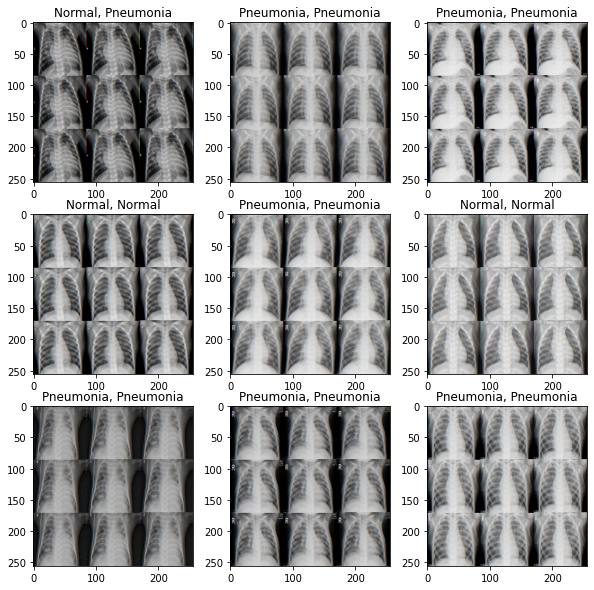

In [46]:
## Find Accuracy on Test Dataset!!
test_loader = DataLoader(dataset=testset, batch_size=9, shuffle=True)
acc = accuracy(test_loader, 9, model)
print("accurarcy : ", acc)

correct : tensor(5031, device='cuda:0')
total : 5216
accuracy :  tensor(96.4532, device='cuda:0')


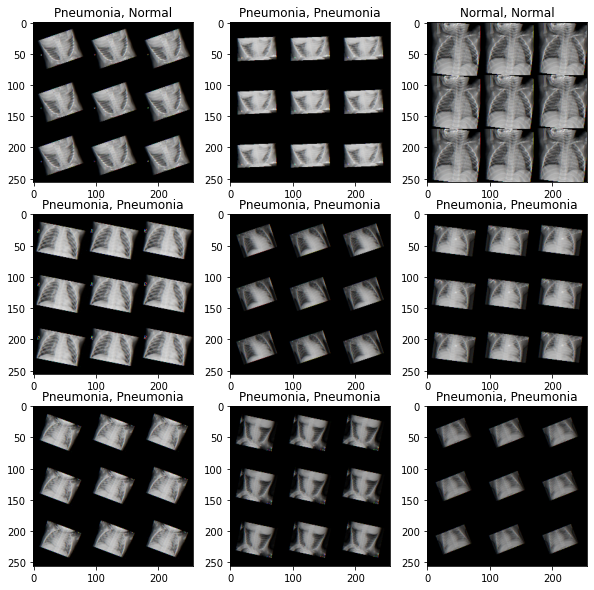

In [47]:
train_loader = DataLoader(dataset=trainset, batch_size=32, shuffle=True)
acc = accuracy(train_loader, 32, model)
print("accuracy : ", acc)

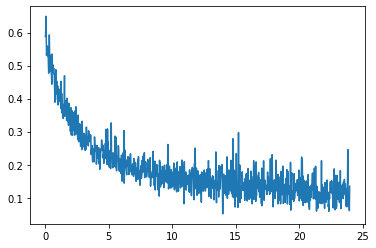

In [48]:
## Run again!! Epoch = 4
# 1) Run and check(PLOT) loss with the existing train function : loss = criterion(outputs, labels.long())
plt.plot(num_list[0:len(loss_list)], loss_list)

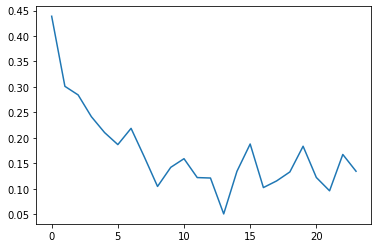

In [49]:
plt.plot([i for i in range(config["epochs"])], loss)

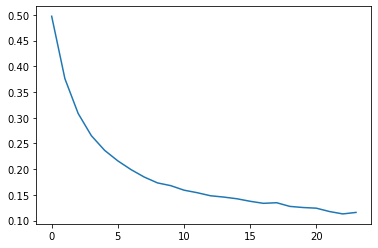

In [50]:
plt.plot([i for i in range(config["epochs"])], loss_avg)